In [1]:
# 💡 Supprime le dossier "dataset" s'il existe
!rm -rf dataset

# 💡 Télécharge le dataset "heart-disease-data" depuis Kaggle
!kaggle datasets download -d redwankarimsony/heart-disease-data

# 💡 Décompresse le fichier ZIP téléchargé dans le dossier "dataset"
!unzip heart-disease-data.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
License(s): copyright-authors
  0% 0.00/12.4k [00:00<?, ?B/s]
100% 12.4k/12.4k [00:00<00:00, 19.0MB/s]
Archive:  heart-disease-data.zip
  inflating: dataset/heart_disease_uci.csv  


In [2]:
# 📌 1. Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# 📌 2. Chargement des données
data = pd.read_csv("./dataset/heart_disease_uci.csv")  # Modifier le chemin si nécessaire
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


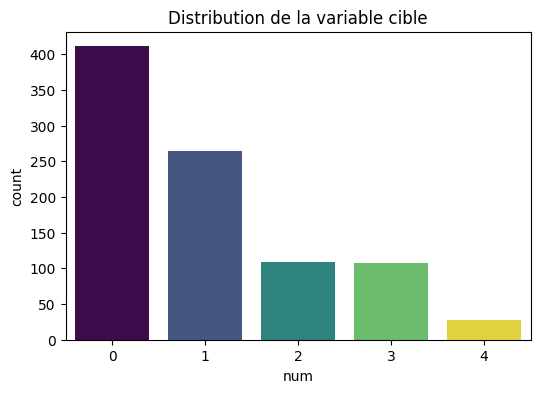

In [4]:
# 📌 3. Visualisation de la distribution de la variable cible
plt.figure(figsize=(6, 4))
sns.countplot(x=data["num"], hue=data["num"], palette="viridis", legend=False)
plt.title("Distribution de la variable cible")
plt.show()

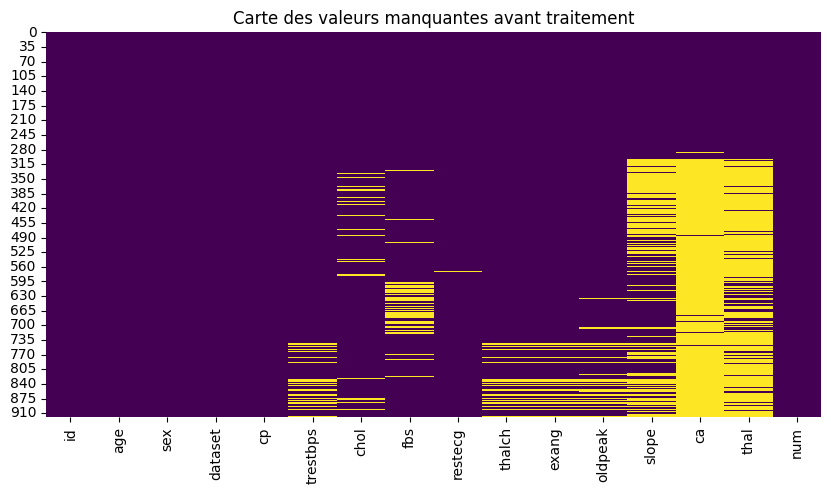

In [5]:
# 📌 4. Vérification des valeurs manquantes
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Carte des valeurs manquantes avant traitement")
plt.show()

In [6]:

# 📌 5. Traitement des valeurs manquantes - Colonnes continues
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



def impute_continuous_missing_data(passed_col):
    data_null = data[data[passed_col].isnull()]
    data_not_null = data[data[passed_col].notnull()]
    X = data_not_null.drop(passed_col, axis=1)
    y = data_not_null[passed_col]
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    label_encoder = LabelEncoder()
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    iterative_imputer = IterativeImputer(estimator=LinearRegression(), add_indicator=True)
    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)

    y_pred = linear_regressor.predict(X_test)
    X = data_null.drop(passed_col, axis=1)
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    if len(data_null) > 0:
        data_null[passed_col] = linear_regressor.predict(X)
    else:
        pass
    data_combined = pd.concat([data_not_null, data_null])
    return data_combined[passed_col]

In [7]:
# 📌 6. Traitement des valeurs manquantes - Colonnes catégorielles
def impute_categorical_missing_data(passed_col):
    data_null = data[data[passed_col].isnull()]
    data_not_null = data[data[passed_col].notnull()]
    X = data_not_null.drop(passed_col, axis=1)
    y = data_not_null[passed_col]
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    label_encoder = LabelEncoder()
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
    iterative_imputer = IterativeImputer(estimator=LogisticRegression(max_iter=1000), add_indicator=True)
    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    logistic_classifier = LogisticRegression(max_iter=1000)
    logistic_classifier.fit(X_train, y_train)
    y_pred = logistic_classifier.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    print("The feature '"+ passed_col + "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")
    X = data_null.drop(passed_col, axis=1)
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    if len(data_null) > 0:
        data_null[passed_col] = logistic_classifier.predict(X)
        if passed_col in bool_cols:
            data_null[passed_col] = data_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass
    data_combined = pd.concat([data_not_null, data_null])

    return data_combined[passed_col]

In [8]:
missing_data_cols = data.isnull().sum()[data.isnull().sum() > 0].index.tolist()
missing_data_cols

['trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalch',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [9]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [10]:
# 📌 6. Traitement des valeurs manquantes
import warnings
warnings.filterwarnings('ignore')

for col in missing_data_cols:
    if col in numeric_cols:
        data[col] = impute_continuous_missing_data(col)
    elif col in categorical_cols:
        data[col] = impute_categorical_missing_data(col)
    else:
        pass

The feature 'fbs' has been imputed with 81.12 accuracy

The feature 'restecg' has been imputed with 63.41 accuracy

The feature 'exang' has been imputed with 76.15 accuracy

The feature 'slope' has been imputed with 69.02 accuracy

The feature 'ca' has been imputed with 61.29 accuracy

The feature 'thal' has been imputed with 69.47 accuracy



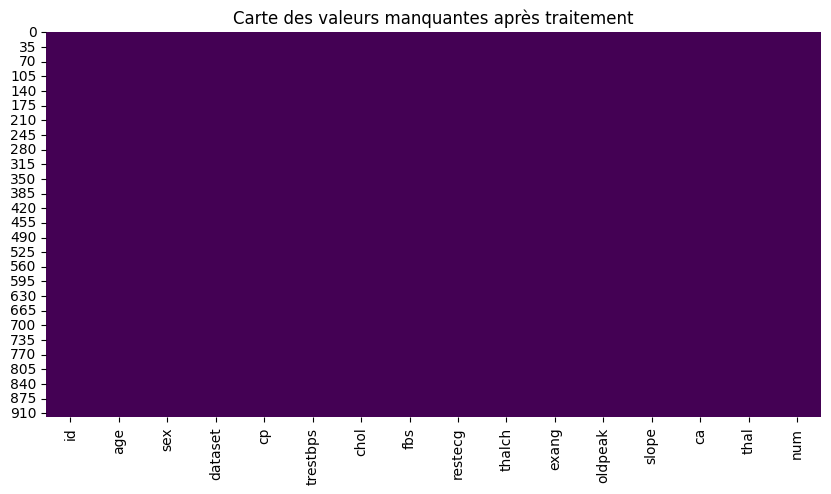

In [11]:

# 📌 7. Vérification après le remplissage
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Carte des valeurs manquantes après traitement")
plt.show()

Columns with outliers: ['trestbps', 'chol', 'thalch', 'oldpeak']


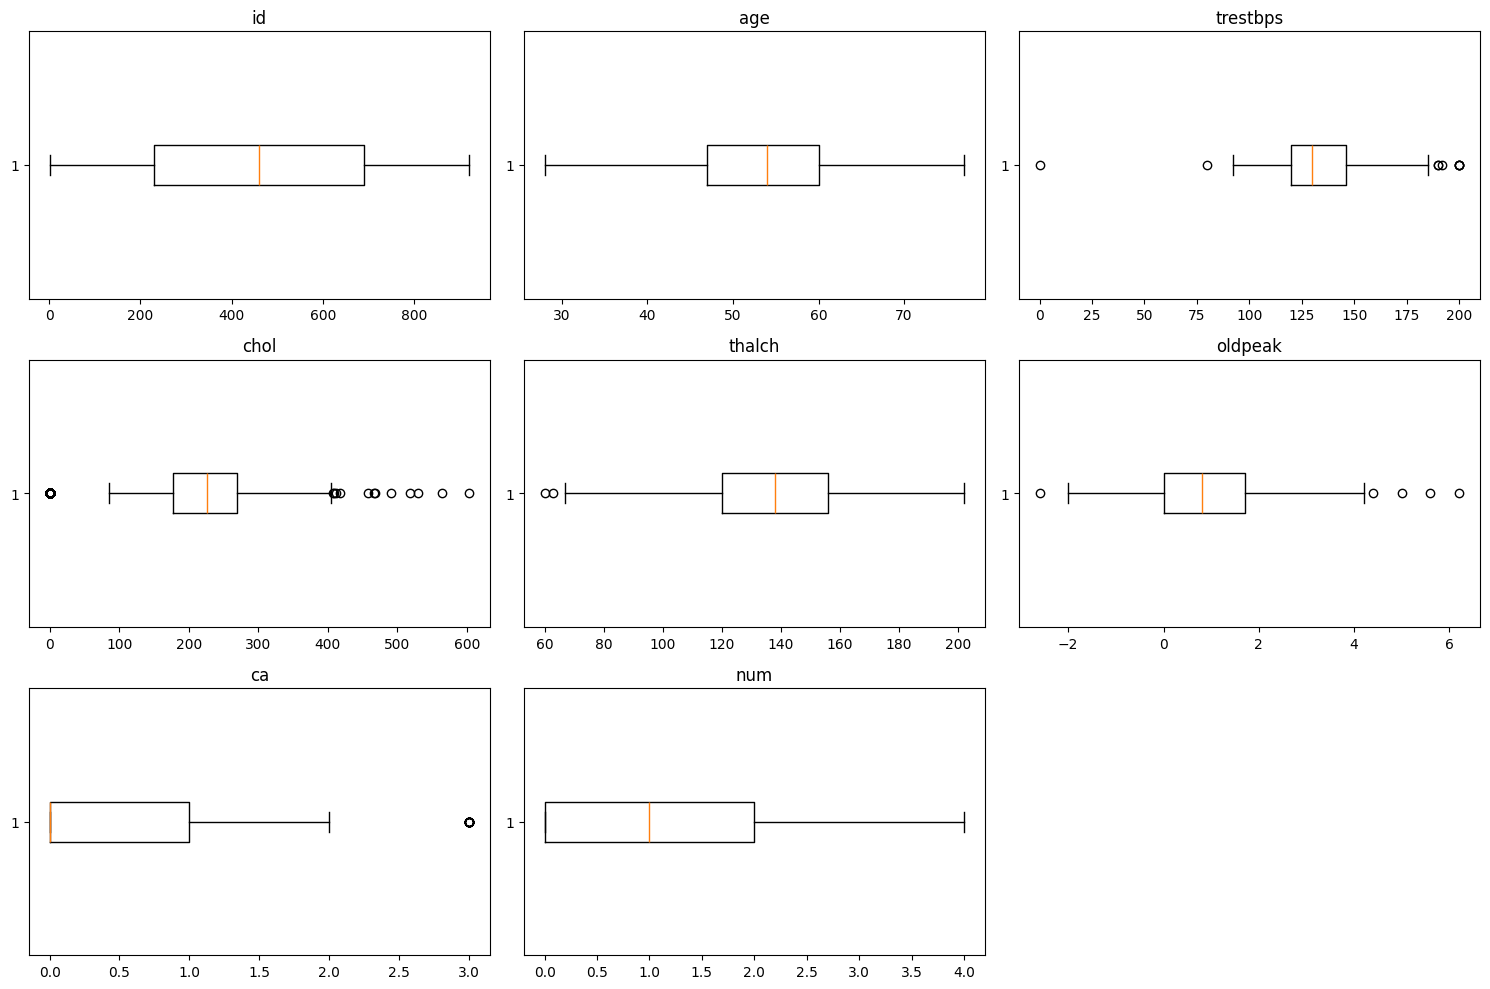

In [12]:
# 📌 8. Détection des valeurs aberrantes avec le Z-score
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt


def detect_outliers_zscore(data, column):
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores > 3]

numerical_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
outlier_columns = []

for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        continue
    outliers_zscore = detect_outliers_zscore(data, col)
    if not outliers_zscore.empty:
        outlier_columns.append(col)

print(f"Columns with outliers: {outlier_columns}")

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(data[col].dropna(), vert=False)
    plt.title(col)
plt.tight_layout()
plt.show()




In [13]:

# 📌 9. Traitement des outliers
def outlier_treatment(data , col):

    z_scores = np.abs((data[col] - data[col].mean()) / data[col].std())

    threshold = 3

    outliers = (z_scores > threshold)

    print(f'Number of rows identified as outliers in {col}: {outliers.sum()}')

    data = data[~outliers]

    print('Z score has been successfully applied on {}.'.format(col))

    return data

In [14]:
for col in outlier_columns:
    data = outlier_treatment(data, col)

Number of rows identified as outliers in trestbps: 6
Z score has been successfully applied on trestbps.
Number of rows identified as outliers in chol: 2
Z score has been successfully applied on chol.
Number of rows identified as outliers in thalch: 1
Z score has been successfully applied on thalch.
Number of rows identified as outliers in oldpeak: 5
Z score has been successfully applied on oldpeak.


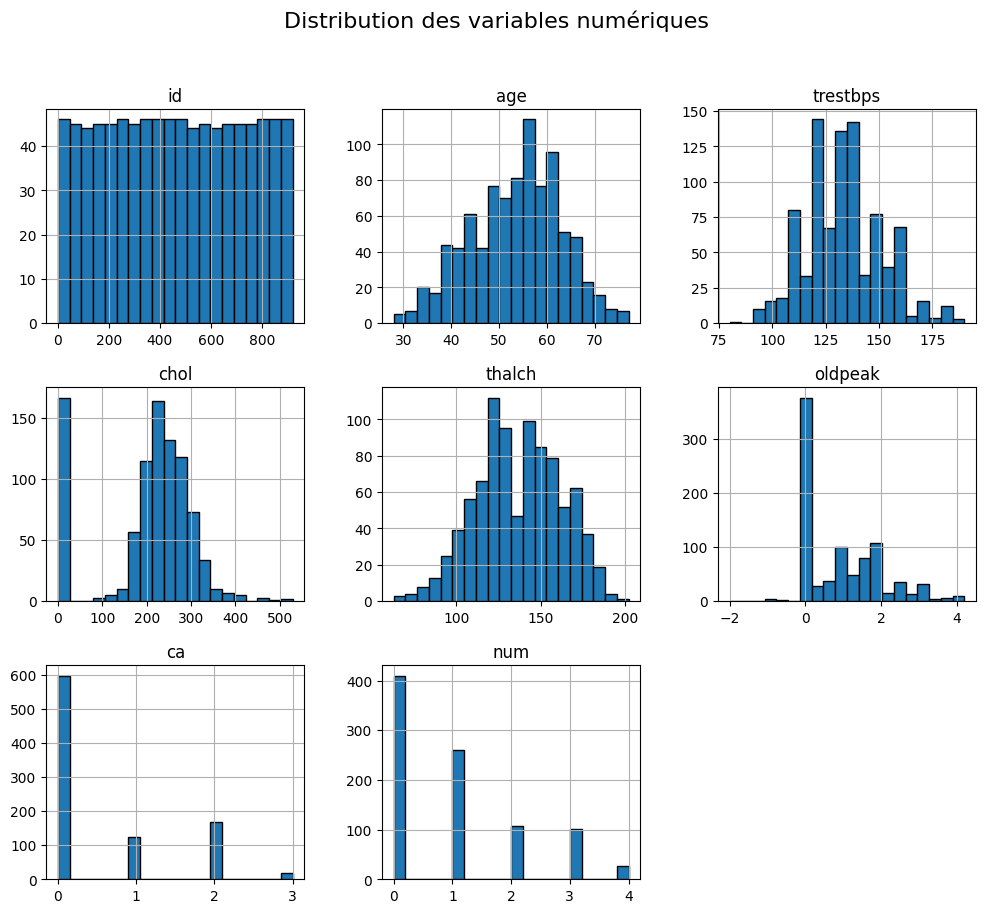

In [15]:
# 📌 10. Vérification de la distribution des variables numériques
data.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Distribution des variables numériques", fontsize=16)
plt.show()

In [16]:
# 📌 11. Encodage des variables catégoriques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = data.drop('num', axis=1)
y = data['num']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical Columns:", categorical_cols)
encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])

Categorical Columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


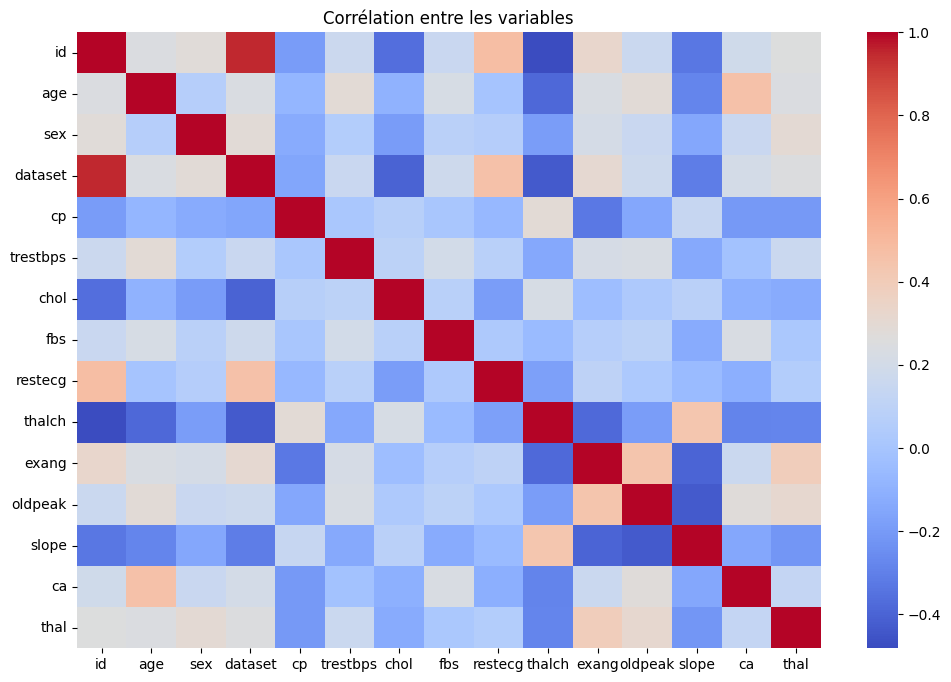

In [17]:
# 📌 12. Matrice de corrélation entre les variables
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Corrélation entre les variables")
plt.show()

In [18]:
# 📌 13. Séparation des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

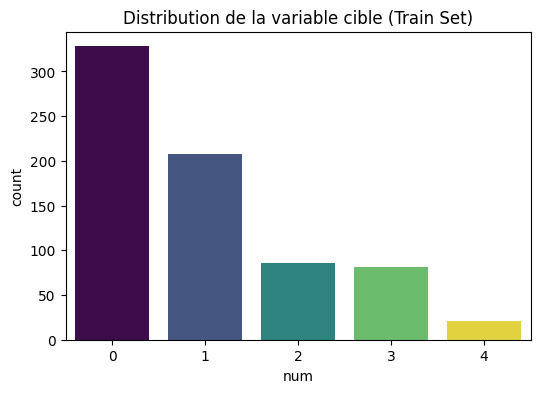

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, hue=y_train, palette="viridis", legend=False)
plt.title("Distribution de la variable cible (Train Set)")
plt.show()

In [20]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler
import seaborn as sns




model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification; change if needed
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,      # Avoid warnings about label encoding

    # Core Hyperparameters
    learning_rate=0.01,            # Step size shrinkage used in updates (default: 0.3)
    n_estimators=20,             # Number of boosting rounds (trees) (default: 100)
    max_depth=3,                  # Maximum depth of a tree (default: 6)
    min_child_weight=2,

    # Tree Construction Parameters
    max_delta_step=0,             # Maximum delta step for each tree's weight estimation (default: 0)
    grow_policy='depthwise',      # Tree growing policy: 'depthwise' or 'lossguide' (default: 'depthwise')

    # Other Parameters
    random_state=30,              # Seed for random number generation (default: None)
    n_jobs=-1,                    # Number of parallel threads (default: 1)
    verbosity=0                   # Verbosity of printing messages (0=silent, 1=warnings, 2=info, 3=debug)
)



model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
# 📌 15. Évaluation du modèle
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
from sklearn.metrics import classification_report
print(f"📊 Accuracy:{accuracy:.2f}")
print("📊 Classification Report:\n", classification_report(y_test, y_pred))

📊 Accuracy:0.71
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        82
           1       0.72      0.65      0.69        52
           2       0.25      0.09      0.13        22
           3       0.48      0.75      0.59        20
           4       0.00      0.00      0.00         6

    accuracy                           0.71       182
   macro avg       0.46      0.49      0.46       182
weighted avg       0.66      0.71      0.67       182



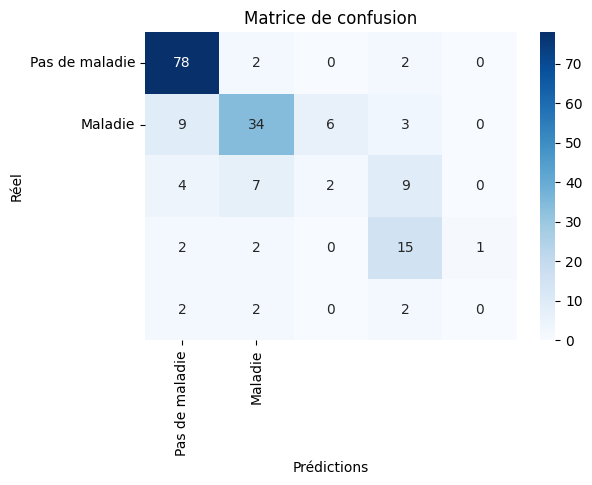

In [22]:
# 📌 16. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pas de maladie', 'Maladie'], yticklabels=['Pas de maladie', 'Maladie'])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

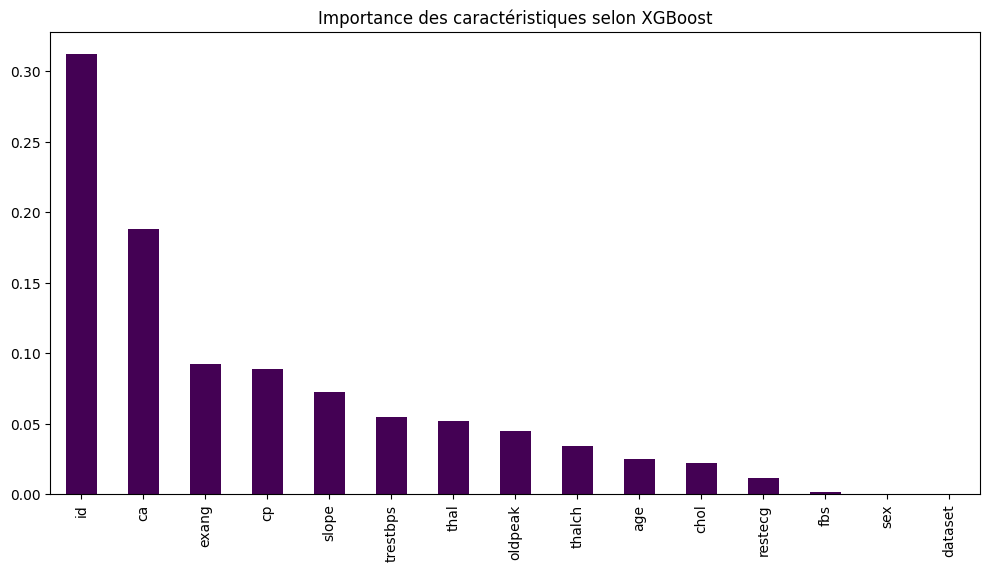

In [23]:
# 📌 17. Visualisation de l'importance des caractéristiques
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Importance des caractéristiques selon XGBoost")
plt.show()

In [24]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Vérifier quelles sont les features réellement utilisées
expected_features = list(model.feature_names_in_)  # Récupérer les features du modèle XGBoost

# Recréer la structure complète avec les colonnes inutiles
patients = pd.DataFrame([
    [999, 45, "Male", 1, "asymptomatic", 130, 233, True, "lv hypertrophy", 150, False, 2.3, "downsloping", 0, "fixed defect"],
    [1000, 60, "Female", 1, "typical angina", 140, 250, False, "normal", 160, True, 1.5, "flat", 2, "normal"],
    [1001, 55, "Male", 1, "non-anginal", 120, 270, False, "lv hypertrophy", 140, False, 2.0, "flat", 1, "reversable defect"],
    [1002, 65, "Female", 1, "asymptomatic", 150, 290, True, "normal", 130, True, 3.0, "downsloping", 3, "fixed defect"],
    [1003, 70, "Male", 1, "asymptomatic", 170, 300, True, "lv hypertrophy", 110, True, 4.0, "flat", 4, "reversable defect"]
], columns=["id", "age", "sex", "dataset", "cp", "trestbps", "chol", "fbs", "restecg", "thalch", "exang", "oldpeak", "slope", "ca", "thal"])

# Encodage des variables catégoriques (si nécessaire)
encoder = LabelEncoder()
for col in ["sex", "cp", "restecg", "slope", "thal"]:
    patients[col] = encoder.fit_transform(patients[col])

# Vérifier que toutes les colonnes du modèle sont bien présentes
patients = patients[expected_features]  # Sélectionner uniquement les colonnes attendues

# Faire les prédictions
predictions = model.predict(patients)

# Dictionnaire pour traduire les prédictions en texte
prediction_labels = {
    0: "Pas de maladie : 0   ",
    1: "Maladie légère : 1   ",
    2: "Maladie modérée : 2   ",
    3: "Maladie sévère : 3   ",
    4: "Maladie très sévère : 4  "
}

# Ajouter les prédictions au DataFrame et remplacer les nombres par les descriptions textuelles
patients["Prediction"] = [prediction_labels[pred] for pred in predictions]

# Afficher le DataFrame mis à jour
patients


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,Prediction
0,999,45,1,1,0,130,233,True,0,150,False,2.3,0,0,0,Pas de maladie : 0
1,1000,60,0,1,2,140,250,False,1,160,True,1.5,1,2,1,Maladie légère : 1
2,1001,55,1,1,1,120,270,False,0,140,False,2.0,1,1,2,Maladie sévère : 3
3,1002,65,0,1,0,150,290,True,1,130,True,3.0,0,3,0,Maladie très sévère : 4
4,1003,70,1,1,0,170,300,True,0,110,True,4.0,1,4,2,Maladie sévère : 3
